# Acknowledgements

The code for the transformer model is take from  this tutorial https://www.tensorflow.org/text/tutorials/transformer

# Installing Packages needed and Importing Libraries

In [1]:
!pip install openpyxl  --quiet

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict
import string
import tensorflow as tf
import re
import os
import time
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [5]:
ENCODER_LEN = 100
DECODER_LEN = 20
BATCH_SIZE = 64
BUFFER_SIZE = BATCH_SIZE*8

# Dataset

After creating the dataframe we apply Start of Sentence(<SOS>) and End of Sentence(<EOS>) tokens. 
These sentences are then tokenized and padded to fix length.

In [47]:
duc=pd.read_excel("../input/duc-2004/duc_2004.xlsx",engine = 'openpyxl')

In [48]:
duc.head()

,text,summary1,summary2,summary3,summary4
0,cambodian leader hun sen on friday rejected op...,Cambodian government rejects opposition's call...,Cambodian leader Hun Sen rejects opposition de...,"Hun Sen rejects out of country talks, Sihanouk...",New Cambodian government in limbo as Hun Sen r...
1,king norodom sihanouk has declined requests to...,Sihanouk refuses to chair Cambodian political ...,Sihanouk refuses to host talks of Cambodian po...,"Efforts to form a government deadlocked, Sihan...",Norodom Sihanouk declines role to mediate in C...
2,cambodia 's two-party opposition asked the asi...,"Opposition asks end to loans to ""illegal"" Camb...",Cambodian opposition asks ADB to stop loans to...,Cambodia's two-party opposition seeks to block...,Opponents of Cambodian government ask Asian De...
3,cambodia 's ruling party responded tuesday to ...,Cambodian party defends leader Hun Sen against...,CPP defends Hun Sen to US Senate. Asks rejecti...,Cambodia's ruling party seeks to counter human...,US House seeks probe of Cambodian rights viola...
4,cambodia 's leading opposition party ruled out...,Cambodian party rejects government offer to sh...,FUNCINPEC refuses to share presidency with CPP...,Disputes over presidency block efforts to form...,Opposition Royalists reject power sharing and ...


In [49]:
news = pd.read_excel("../input/inshorts-news-data/Inshorts Cleaned Data.xlsx",engine = 'openpyxl')
news.drop(['Source ', 'Time ', 'Publish Date'], axis=1, inplace=True)
news.head()
print(f'Dataset size: {len(news)}')

Dataset size: 55104


In [50]:
duc_columns = duc.columns.tolist()
duc_columns.remove('text')
duc_columns.remove('summary1')
duc.drop(duc_columns, axis='columns', inplace=True)


In [51]:
duc

,text,summary1
0,cambodian leader hun sen on friday rejected op...,Cambodian government rejects opposition's call...
1,king norodom sihanouk has declined requests to...,Sihanouk refuses to chair Cambodian political ...
2,cambodia 's two-party opposition asked the asi...,"Opposition asks end to loans to ""illegal"" Camb..."
3,cambodia 's ruling party responded tuesday to ...,Cambodian party defends leader Hun Sen against...
4,cambodia 's leading opposition party ruled out...,Cambodian party rejects government offer to sh...
...,...,...
495,"german foreign minister joschka fischer , who ...",German Foreign Minister says China's arrest of...
496,the trials of three outspoken dissidents over ...,President Jiang vows to crush any challenges t...
497,"his friend and political mentor is jailed , ro...",China Democracy Party vows to campaign for cha...
498,by sentencing two of the country 's most promi...,China's arrest of dissidents could destroy Chi...


In [52]:
duc.rename(columns = { 'summary1':'Headline','text':'Short'}, inplace = True)

In [53]:
duc

,Short,Headline
0,cambodian leader hun sen on friday rejected op...,Cambodian government rejects opposition's call...
1,king norodom sihanouk has declined requests to...,Sihanouk refuses to chair Cambodian political ...
2,cambodia 's two-party opposition asked the asi...,"Opposition asks end to loans to ""illegal"" Camb..."
3,cambodia 's ruling party responded tuesday to ...,Cambodian party defends leader Hun Sen against...
4,cambodia 's leading opposition party ruled out...,Cambodian party rejects government offer to sh...
...,...,...
495,"german foreign minister joschka fischer , who ...",German Foreign Minister says China's arrest of...
496,the trials of three outspoken dissidents over ...,President Jiang vows to crush any challenges t...
497,"his friend and political mentor is jailed , ro...",China Democracy Party vows to campaign for cha...
498,by sentencing two of the country 's most promi...,China's arrest of dissidents could destroy Chi...


In [54]:
news

,Headline,Short
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a..."
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...
...,...,...
55099,Sensex loses 400 points to hit 52-week low,"Tracking weak cues from the Asian markets, the..."
55100,China to inject $91 bn into the money markets,Amid growing concerns about China&#39;s econom...
55101,Ghulam Ali set to make acting debut in Bollywood,Pakistani Ghazal singer Ghulam Ali will soon m...
55102,IS acknowledges death of Jihadi John: Report,The Islamic State (IS) has acknowledged the de...


In [70]:
#df = pd.concat([duc, news])
#del df1, df2
df = pd.concat([duc, news], ignore_index=True, sort=False)
# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
news=df

Dataset size: 55604


In [75]:
news.head()

,Short,Headline
0,US Defense Secretary Ashton Carter on Tuesday ...,India shows responsible behaviour with nuke te...
1,Congress President Sonia Gandhi will reportedl...,Sonia Gandhi to protest against U&#39;khand cr...
2,Actor Salman Khan has said that Pakistani acto...,Pakistani actors are not terrorists: Salman Khan
3,The world&#39;s most expensive car license pla...,World&#39;s most expensive license plate was s...
4,Pakistan PM Nawaz Sharif on Monday condemned t...,Pak PM condemns killing of Hizbul commander Wani


In [68]:
text= " my name is sandeep&#39;s kumar"
text=text.replace(r'&#39;','`')#.replace(r'&#39;','`', regex=True).replace(r'&amp','&', regex=True).replace(r'&#34;','"', regex=True)

In [69]:
text

' my name is sandeep`s kumar'

In [76]:
news=news.replace(r'&#45;','-', regex=True).replace(r'&#39;','`', regex=True).replace(r'&amp','&', regex=True).replace(r'&#34;','"', regex=True)
news.head()

,Short,Headline
0,US Defense Secretary Ashton Carter on Tuesday ...,India shows responsible behaviour with nuke te...
1,Congress President Sonia Gandhi will reportedl...,Sonia Gandhi to protest against U`khand crisis
2,Actor Salman Khan has said that Pakistani acto...,Pakistani actors are not terrorists: Salman Khan
3,The world`s most expensive car license plate w...,World`s most expensive license plate was sold ...
4,Pakistan PM Nawaz Sharif on Monday condemned t...,Pak PM condemns killing of Hizbul commander Wani


In [77]:
article = news['Short']
summary = news['Headline']




article = article.apply(lambda x: '<SOS> ' + x + ' <EOS>')
summary = summary.apply(lambda x: '<SOS> ' + x + ' <EOS>')

In [78]:
def preprocess(text):
    text = re.sub(r"&.[1-9]+;"," ",text)
    return text
article = article.apply(lambda x: preprocess(x))
summary = summary.apply(lambda x: preprocess(x))

In [79]:
article[8]

'<SOS> Madhya Pradesh CM Shivraj Singh Chouhan will begin his three-day tour to the UK from Sunday. Chouhan will eye investment in defence equipment manufacturing units and industrial sectors like steel, and meet potential investors including the Vice-President of Rolls-Royce and the Hinduja Group`s Co-chairman. The visit follows an invitation by the UK`s Secretary of State for International Development. <EOS>'

In [80]:

print("****************************")
summary[8]

****************************


'<SOS> Madhya Pradesh CM to begin three-day visit to UK <EOS>'

In [81]:
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n'
oov_token = '<unk>'
article_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=filters, oov_token=oov_token)
article_tokenizer.fit_on_texts(article)
summary_tokenizer.fit_on_texts(summary)
inputs = article_tokenizer.texts_to_sequences(article)
targets = summary_tokenizer.texts_to_sequences(summary)

In [82]:
ENCODER_VOCAB = len(article_tokenizer.word_index) + 1
DECODER_VOCAB = len(summary_tokenizer.word_index) + 1
print(ENCODER_VOCAB, DECODER_VOCAB)

76618 29955


In [83]:
inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs, maxlen=ENCODER_LEN, padding='post', truncating='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, maxlen=DECODER_LEN, padding='post', truncating='post')
inputs = tf.cast(inputs, dtype=tf.int64)
targets = tf.cast(targets, dtype=tf.int64)

In [84]:
dataset = tf.data.Dataset.from_tensor_slices((inputs, targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Transformer Model

The next several blocks of code contain the vanilla Transformer model.

If you want to know about what they are and how they work I suggest this video: https://www.youtube.com/watch?v=4Bdc55j80l8

It does an excellent job of giving an overview about them and helped me in understanding them.

In [85]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights


In [86]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights
    
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [87]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [88]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [89]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x
    
class Decoder(tf.keras.layers.Layer):
        
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights
    

In [90]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)

        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [91]:
num_layers = 3
d_model = 128
dff = 512
num_heads = 4
dropout_rate = 0.2
EPOCHS = 30

# Custom Learning Rate

In [92]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [93]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

Text(0.5, 0, 'Train Step')

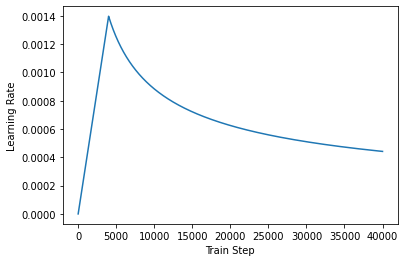

In [94]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Custom Loss and Accuracy

In [95]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    #accuracies = tf.cast(accuracies, dtype= tf.float32)

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [96]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [97]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=ENCODER_VOCAB,
    target_vocab_size=DECODER_VOCAB,
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [98]:
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [99]:
checkpoint_path = "checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [100]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

# Training the Model

It trained on two time for epoch=15 ( loss upto 3.somthing and accuracy upto 33.something) and epoch=15 so total 30 epochs

In [101]:
for epoch in range(EPOCHS):
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        train_step(inp, tar)
    
        if batch % 100 == 0:
            print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
      
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
   
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 10.3058 Accuracy 0.0000
Epoch 1 Batch 100 Loss 10.2056 Accuracy 0.0645
Epoch 1 Batch 200 Loss 9.9997 Accuracy 0.0840
Epoch 1 Batch 300 Loss 9.7036 Accuracy 0.0905
Epoch 1 Batch 400 Loss 9.3618 Accuracy 0.0937
Epoch 1 Batch 500 Loss 9.0438 Accuracy 0.0957
Epoch 1 Batch 600 Loss 8.7989 Accuracy 0.0971
Epoch 1 Batch 700 Loss 8.6109 Accuracy 0.1004
Epoch 1 Batch 800 Loss 8.4612 Accuracy 0.1035
Epoch 1 Loss 8.3733 Accuracy 0.1055
Time taken for 1 epoch: 233.09787464141846 secs

Epoch 2 Batch 0 Loss 7.2744 Accuracy 0.1055
Epoch 2 Batch 100 Loss 7.2462 Accuracy 0.1084
Epoch 2 Batch 200 Loss 7.2120 Accuracy 0.1112
Epoch 2 Batch 300 Loss 7.1789 Accuracy 0.1139
Epoch 2 Batch 400 Loss 7.1377 Accuracy 0.1162
Epoch 2 Batch 500 Loss 7.0933 Accuracy 0.1184
Epoch 2 Batch 600 Loss 7.0478 Accuracy 0.1204
Epoch 2 Batch 700 Loss 7.0028 Accuracy 0.1225
Epoch 2 Batch 800 Loss 6.9572 Accuracy 0.1245
Epoch 2 Loss 6.9252 Accuracy 0.1258
Time taken for 1 epoch: 224.9121913909912 secs

Epoch

In [130]:
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

NameError: name 'history' is not defined

# Evaluation

In [102]:
def evaluate(input_article):
    input_article = article_tokenizer.texts_to_sequences([input_article])
    input_article = tf.keras.preprocessing.sequence.pad_sequences(input_article, maxlen=ENCODER_LEN, 
                                                                   padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_article[0], 0)

    decoder_input = [summary_tokenizer.word_index['<sos>']]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(DECODER_LEN):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index['<eos>']:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [103]:
def summarize(input_article):
    input_article=preprocess(input_article)
    summarized = evaluate(input_article=input_article)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  
    return summary_tokenizer.sequences_to_texts(summarized)[0]

# Predictions

Below me make predictions on some texts to see how the model is performimg. Since this was a very basic approach the model wont perform that well but it can surely be improved.

In [104]:
article[5]

'<SOS> Former Indian cricket captain MS Dhoni, who hails from Ranchi in Jharkhand, is set to lead his state`s cricket side in the Vijay Hazare Trophy starting February 25. The announcement comes two days after Dhoni was removed as the captain of the Indian Premier League side Rising Pune Supergiants. Dhoni stepped down as India`s limited overs captain in January.  <EOS>'

In [105]:
print("Real Headline : ", summary[5][5:-5],"\n Predicted Summary : ", summarize(article[5]))

Real Headline :   MS Dhoni set to lead Jharkhand in Vijay Hazare Trophy  
 Predicted Summary :  dhoni to lead jharkhand t20 trophy


In [106]:
article[16]

'<SOS> Google on Tuesday launched a new iOS app, called `Motion Stills`, that stabilises blurry live photos and allows its users to turn live photos into shareable GIFs. The new app tries to determine the photo`s background and foreground to isolate them for better stabilization and then tries to determine the best starting and ending point for the loop. <EOS>'

In [107]:
print("Real Headline : ", summary[16][5:-5],"\nPredicted Summary : ", summarize(article[16]))

Real Headline :   Google`s new iOS app turns live photos into GIFs  
Predicted Summary :  google s new ios app turns live photos into gifs


In [108]:
article[23]

'<SOS> Responding to the fatality believed to be caused by Tesla`s Autopilot mode, the company released a statement which said, "Customers using Autopilot are statistically safer than those not using it at all." Tesla added, "To be clear, this accident was the result of a semi-tractor trailer crossing both lanes of a divided highway in front of an oncoming car." <EOS>'

In [109]:
print("Real Headline : ", summary[23][5:-5],"\nPredicted Summary : ", summarize(article[23]))

Real Headline :   Autopilot user safer than regular driver: Tesla  
Predicted Summary :  autopilot user when we are over cars killed tesla asks autopilot


In [110]:
print("Real Headline : ", summary[0][5:-5],"\nPredicted Summary : ", summarize(article[0]))

Real Headline :   India shows responsible behaviour with nuke technology: US  
Predicted Summary :  india shows responsible with nuclear weapons us


In [111]:
print("Real Headline : ", summary[23][5:-5],"\nPredicted Summary : ", summarize(article[23]))

Real Headline :   Autopilot user safer than regular driver: Tesla  
Predicted Summary :  autopilot user when we are over cars killed tesla asks autopilot


In [112]:
summarize("Text Summarization - as the name suggests - involves generating short summaries of text data, in a few words or sentences. A good example of this in day-to-day life is the Inshorts news summary app, which generates summaries upto max of ~ 60 words.")

'used coding language of over ends'

In [113]:
summarize("""Cambodian leader Hun Sen on Friday rejected opposition parties' demands 
for talks outside the country, accusing them of trying to ``internationalize'' 
the political crisis. Government and opposition parties have asked 
King Norodom Sihanouk to host a summit meeting after a series of post-election 
negotiations between the two opposition groups and Hun Sen's party 
to form a new government failed. Opposition leaders Prince Norodom 
Ranariddh and Sam Rainsy, citing Hun Sen's threats to arrest opposition 
figures after two alleged attempts on his life, said they could not 
negotiate freely in Cambodia and called for talks at Sihanouk's residence 
in Beijing. Hun Sen, however, rejected that. ``I would like to make 
it clear that all meetings related to Cambodian affairs must be conducted 
in the Kingdom of Cambodia,'' Hun Sen told reporters after a Cabinet 
meeting on Friday. ``No-one should internationalize Cambodian affairs. 
It is detrimental to the sovereignty of Cambodia,'' he said. Hun Sen's 
Cambodian People's Party won 64 of the 122 parliamentary seats in 
July's elections, short of the two-thirds majority needed to form 
a government on its own. Ranariddh and Sam Rainsy have charged that 
Hun Sen's victory in the elections was achieved through widespread 
fraud. They have demanded a thorough investigation into their election 
complaints as a precondition for their cooperation in getting the 
national assembly moving and a new government formed. Hun Sen said 
on Friday that the opposition concerns over their safety in the country 
was ``just an excuse for them to stay abroad.'' Both Ranariddh and 
Sam Rainsy have been outside the country since parliament was ceremonially 
opened on Sep. 24. Sam Rainsy and a number of opposition figures have 
been under court investigation for a grenade attack on Hun Sen's Phnom 
Penh residence on Sep. 7. Hun Sen was not home at the time of the 
attack, which was followed by a police crackdown on demonstrators 
contesting Hun Sen's election victory. The Sam Rainsy Party, in a 
statement released Friday, accused Hun Sen of being ``unwilling to 
make any compromise'' on negotiations to break the deadlock. ``A meeting 
outside Cambodia, as suggested by the opposition, could place all 
parties on more equal footing,'' said the statement. ``But the ruling 
party refuses to negotiate unless it is able to threaten its negotiating 
partners with arrest or worse.'' """)

'cambodian opposition rejects opposition party for political crisis'

In [114]:
summarize("cambodian leader hun sen on friday rejected opposition parties ' demands for talks outside the country , accusing them of trying to `` internationalize '' the political crisis .")

'cambodian opposition rejects talks for talks over government'

Cambodian government rejects opposition's call for talks abroad


In [115]:
summarize("king norodom sihanouk has declined requests to chair a summit of cambodia 's top political leaders , saying the meeting would not bring any progress in deadlocked negotiations to form a government .")

'king declines to chair cambodian political summit at home min meet'

In [116]:
summarize("sometime in the summer of 1997 , an operative for osama bin laden sat down at his personal computer in a hideaway in kenya , he was worried , he wrote in an angry dispatch , about the security of the `` east africa network '' of bin laden , the saudi exile accused of masterminding a worldwide terrorist conspiracy against americans .")

'bin laden million from behind network cricketers'

In [117]:
summarize("six months after president clinton traveled to beijing and challenged china 's leaders to move rapidly toward political reform , the administration 's policy of engaging beijing was called into question monday when chinese courts sentenced three of the nation 's most prominent dissidents to long jail sentences .")

'u s policy of policy is policy of reform'

In [118]:
summarize("fbi agents this week began questioning relatives of the victims of the aug. 7 u.s. embassy bombing as well as the seriously injured on request of the u.s. attorney 's office for the southern district of new york , a u.s. official said thursday .")

'fbi questions us bombing suspects for bombing suspects'

In [125]:
summarize("Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.")

'boss 10 smart engineer gets lessons at ₹10 5 yrs'

In [126]:
summarize("Actor Ranbir Kapoor worked as an assistant director for Sanjay Leela Bhansali&#39;s &#39;Black&#39; in 2005. He is also known to have assisted in the making of the 1996 film &#39;PremGranth&#39; and his father Rishi Kapoor&#39;s directorial debut &#39;Aa Ab Laut Chalen&#39; in 1999. The actor, who has won five Filmfare awards including Best Actor for &#39;Barfi!&#39;, turned 34 on Wednesday.")

'ranbir kapoor worked as tool for black film journalist'

In [128]:
print("Real Headline : ", summary[0][5:-5],"\nPredicted Summary : ", summarize(article[0]))

Real Headline :   India shows responsible behaviour with nuke technology: US  
Predicted Summary :  india shows responsible with nuclear weapons us


In [129]:
summarize("The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.")

'4 ex bank officials booked for cheating bank of ₹209 crore'